<a href="https://colab.research.google.com/github/Shubham07-bit/Burger-s-Eqaution-using-pinn/blob/main/Burger's_Equation_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PhysicsInformedNN**

## Introduction
The _PhysicsInformedNN_ class is designed to solve the Burgers' equation using neural networks. It utilizes the finite difference method to approximate derivatives and trains a neural network to minimize the error between the predicted and actual solutions.

## Constructor
### `__init__(self, X_u, u, X_f)`
- **Parameters:**
  - *X_u*: numpy array, shape _(N_u, 2)_, containing boundary condition points (_x_, _t_)
  - *u*: numpy array, shape _(N_u, 1)_, containing the corresponding boundary solution values
  - *X_f*: numpy array, shape _(N_f, 2)_, containing collocation points (_x_, _t_)
- **Description:** Initializes the class instance with boundary condition and collocation point data, defines the neural network, loss function, and optimizer.

## Methods
### `create_net(self)`
- **Description:** Creates the neural network model with a predefined architecture consisting of several fully connected layers.

### `init_weights(self, m)`
- **Parameters:**
  - *m*: torch.nn.Module, a layer of the neural network
- **Description:** Initializes the weights of the neural network using Xavier initialization and sets the bias values.

### `net_u(self, x, t)`
- **Parameters:**
  - *x*: torch.Tensor, input tensor for spatial coordinate
  - *t*: torch.Tensor, input tensor for temporal coordinate
- **Returns:** torch.Tensor, the predicted solution _u_ at the given (_x_, _t_) coordinates.

### `net_f(self, x, t)`
- **Parameters:**
  - *x*: torch.Tensor, input tensor for spatial coordinate
  - *t*: torch.Tensor, input tensor for temporal coordinate
- **Returns:** torch.Tensor, the residual _f_ at the given (_x_, _t_) coordinates.

### `plot_u_vs_x(self, t_values, x_range)`
- **Parameters:**
  - *t_values*: list of float, containing multiple time points for plotting
  - *x_range*: numpy array, representing the range of spatial coordinates for plotting
- **Description:** Plots the predicted solution _u(t,x)_ versus _x_ for each time point specified in *t_values*.

### `plot(self)`
- **Description:** Plots the solution _u(t,x)_ on a grid of spatial and temporal coordinates.

### `closure(self)`
- **Description:** Computes the loss function and its gradients for a single optimization step (LBFGS).

### `train(self)`
- **Description:** Trains the neural network by optimizing the loss function using LBFGS optimization.

### `save_model(self, filepath)`
- **Parameters:**
  - *filepath*: str, the file path where the model will be saved
- **Description:** Saves the trained model parameters to a file.

### `load_model(self, file_path)`
- **Parameters:**
  - *file_path*: str, the file path from which the model will be loaded
- **Description:** Loads a saved model from a file.



In [43]:
import torch
import torch.nn as nn
import numpy as np
from random import uniform
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f):
        # x & t from boundary conditions:
        self.x_u = torch.tensor(X_u[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)
        self.t_u = torch.tensor(X_u[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)
        # x & t from collocation points:
        self.x_f = torch.tensor(X_f[:, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)
        self.t_f = torch.tensor(X_f[:, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True)
        # boundary solution:
        self.u = torch.tensor(u, dtype=torch.float32)

        # null vector to test against f:
        self.null =  torch.zeros((self.x_f.shape[0], 1))

         # initialize net:
        self.create_net()
        #self.net.apply(self.init_weights)

        # this optimizer updates the weights and biases of the net:
        self.optimizer = torch.optim.LBFGS(self.net.parameters(),
                                    lr=1,
                                    max_iter=50000,
                                    max_eval=50000,
                                    history_size=50,
                                    tolerance_grad=1e-05,
                                    tolerance_change=0.5 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")

        # typical MSE loss (this is a function):
        self.loss = nn.MSELoss()

        # loss :
        self.ls = 0

        # iteration number:
        self.iter = 0

    def create_net(self):
        """ net takes a batch of two inputs: (n, 2) --> (n, 1) """
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1))

    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_normal_(m.weight, 0.1)
            m.bias.data.fill_(0.001)

    def net_u(self, x, t):
        u = self.net( torch.hstack((x, t)) )
        return u

    def net_f(self, x, t):
        u = self.net_u(x, t)

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]

        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]

        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]

        f = u_t + (u * u_x) - (nu * u_xx)

        return f

    # Define a function to plot u(t,x) versus x for multiple time points
    def plot_u_vs_x(self, t_values, x_range):
        num_plots = len(t_values)

        # Create subplots
        fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

        for i, t_fixed in enumerate(t_values):
            u_values = []
            for x_fixed in x_range:
                # Calculate u(t,x) for a fixed t and varying x
                u_t_x = self.net_u(torch.tensor(x_fixed, dtype=torch.float), torch.tensor(t_fixed))
                u_values.append(u_t_x.item())  # Append the calculated u value

            # Plot u(t,x) versus x for the current time point
            axs[i].plot(x_range, u_values)
            axs[i].set_xlabel('x')
            axs[i].set_ylabel('u(t,x)')
            axs[i].set_title('u(t,x) at t = {}'.format(t_fixed))

        plt.tight_layout()
        plt.show()

    def plot(self):
        """ plot the solution on new data """

        import matplotlib.pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable

        x = torch.linspace(-1, 1, 200)
        t = torch.linspace( 0, 1, 100)

        # x & t grids:
        X, T = torch.meshgrid(x, t)

        # x & t columns:
        xcol = X.reshape(-1, 1)
        tcol = T.reshape(-1, 1)

        # one large column:
        usol = self.net_u(xcol, tcol)

        # reshape solution:
        U = usol.reshape(x.numel(), t.numel())

        # transform to numpy:
        xnp = x.numpy()
        tnp = t.numpy()
        Unp = U.detach().numpy()

        # plot:
        fig = plt.figure(figsize=(9, 4.5))
        ax = fig.add_subplot(111)

        h = ax.imshow(Unp,
                      interpolation='nearest',
                      cmap='rainbow',
                      extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()],
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.10)
        cbar = fig.colorbar(h, cax=cax)
        cbar.ax.tick_params(labelsize=10)
        plt.show()

    def closure(self):
        # reset gradients to zero:
        self.optimizer.zero_grad()

        # u & f predictions:
        u_prediction = self.net_u(self.x_u, self.t_u)
        f_prediction = self.net_f(self.x_f, self.t_f)

        # losses:
        u_loss = self.loss(u_prediction, self.u)
        f_loss = self.loss(f_prediction, self.null)
        self.ls = u_loss + f_loss

        # derivative with respect to net's weights:
        self.ls.backward()

        # increase iteration count:
        self.iter += 1

        # print report:
        if not self.iter % 100:
            print('Epoch: {0:}, Loss: {1:6.3f}'.format(self.iter, self.ls))

        return self.ls

    def train(self):
        """ training loop """
        self.net.train()
        self.optimizer.step(self.closure)

    def save_model(self, filepath):
        torch.save(self.net.state_dict(), filepath)

    def load_model(self, file_path):
        """Load a saved model from a file."""
        try:
            self.net.load_state_dict(torch.load(file_path))
            self.net.eval()  # Set the model to evaluation mode
            print("Model loaded successfully.")
        except FileNotFoundError:
            print("Model file not found.")
        except Exception as e:
            print("An error occurred while loading the model:", e)




# **Boundary and Collocation Point Generation**

## Introduction
This code snippet generates boundary and collocation points for solving Burgers' equation using neural networks. It defines the viscosity constant, the number of points, and randomly generates points based on specified conditions.

## Code Explanation
1. **Viscosity Constant Definition**: The viscosity constant (ν) is defined as 0.01 divided by π.

2. **Number of Points Definition**: Two variables, *N_u* and *N_f*, define the number of boundary and collocation points, respectively.

3. **Boundary Condition Points Generation**:
   - *x_upper*, *x_lower*, and *t_zero* arrays are initialized based on the specified conditions.
   - Random values are generated for *t_upper*, *t_lower*, and *x_zero* arrays within the defined ranges.
   - Boundary condition points are stacked to form *X_u_train*.

4. **Shuffle and Combine Boundary Points**: Boundary points are shuffled and combined into *X_u_train*.

5. **Collocation Points Generation**:
   - *X_f_train* is initialized as a zero array of size *(N_f, 2)*.
   - Random values for *x* and *t* are generated and added to *X_f_train*.
   - Boundary points are added to the collocation points to form *X_f_train*.

6. **Solution Values Generation**:
   - Arrays *u_upper*, *u_lower*, and *u_zero* are initialized based on boundary conditions.
   - Solution values are stacked to form *u_train*.

7. **Figure Setup for Animation**:
   - A figure and axis are set up for animation using matplotlib.

8. **Update Function for Animation**:
   - The *update* function clears the axis and updates the plot with boundary and collocation points.
   - It also updates the title with the current number of data points.

9. **Animation Creation**:
   - Using *FuncAnimation*, the animation is created with the defined update function and specified frames and interval.

10. **Display Animation**:
    - The animation is displayed using HTML.




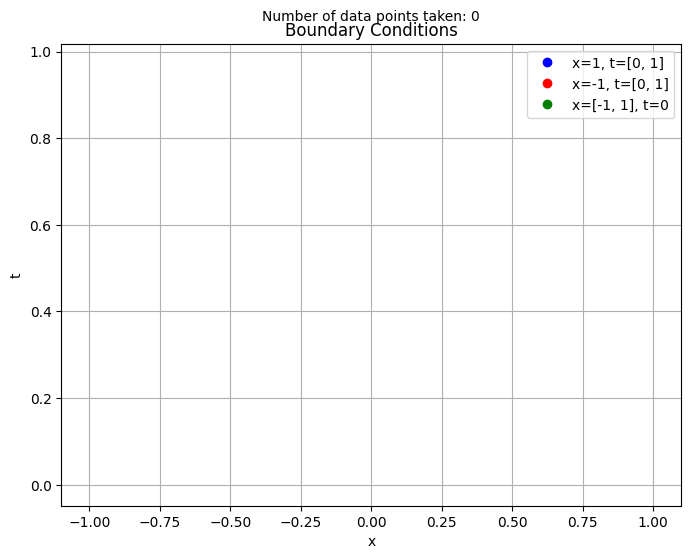

In [44]:
# Define the viscosity constant
nu = 0.01 / np.pi

# Define the number of points
N_u = 100
N_f = 10000

# Generate points according to the specified conditions
x_upper = np.ones((N_u // 4, 1))
x_lower = np.ones((N_u // 4, 1)) * (-1)
t_zero = np.zeros((N_u // 2, 1))

t_upper = np.random.rand(N_u // 4, 1)
t_lower = np.random.rand(N_u // 4, 1)
x_zero = (-1) + np.random.rand(N_u // 2, 1) * (1 - (-1))

# stack uppers, lowers, and zeros:
X_upper = np.hstack((x_upper, t_upper))  # Switched t and x for upper wall
X_lower = np.hstack((x_lower, t_lower))  # Switched t and x for lower wall
X_zero = np.hstack((x_zero, t_zero))

# Combine boundary condition points
X_u_train = np.vstack((X_upper, X_lower, X_zero))

# Shuffle X_u_train
index = np.arange(0, N_u)
np.random.shuffle(index)
X_u_train = X_u_train[index, :]

# Make X_f_train
X_f_train = np.zeros((N_f, 2), dtype=float)
for row in range(N_f):
    x = uniform(-1, 1)  # x range
    t = uniform(0, 1)   # t range

    X_f_train[row, 0] = x  # Switched t and x for collocation points
    X_f_train[row, 1] = t

# Add the boundary points to the collocation points
X_f_train = np.vstack((X_f_train, X_u_train))

# Make u_train
u_upper = np.zeros((N_u // 4, 1), dtype=float)
u_lower = np.zeros((N_u // 4, 1), dtype=float)
u_zero = -np.sin(np.pi * x_zero)

# Stack them in the same order as X_u_train was stacked
u_train = np.vstack((u_upper, u_lower, u_zero))

# Match indices with X_u_train
u_train = u_train[index, :]



# Set up the figure and axis for animation
fig, ax = plt.subplots(figsize=(8, 6))

# Define the update function for animation
def update(frame):
    ax.clear()
    ax.plot(x_upper[:frame], t_upper[:frame], 'bo', label='x=1, t=[0, 1]')  # Changed plot order for upper wall
    ax.plot(x_lower[:frame], t_lower[:frame], 'ro', label='x=-1, t=[0, 1]')  # Changed plot order for lower wall
    ax.plot(x_zero[:frame], t_zero[:frame], 'go', label='x=[-1, 1], t=0')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_title('Boundary Conditions')
    ax.legend()
    ax.grid(True)
    ax.text(0.5, 1.05, f'Number of data points taken: {frame}', transform=ax.transAxes, ha='center')

# Create the animation
ani = FuncAnimation(fig, update, frames=N_u, interval=100)

# Display the animation
HTML(ani.to_html5_video())

### Initializing NN


In [45]:
pinn = PhysicsInformedNN(X_u_train, u_train, X_f_train)

### Result before training

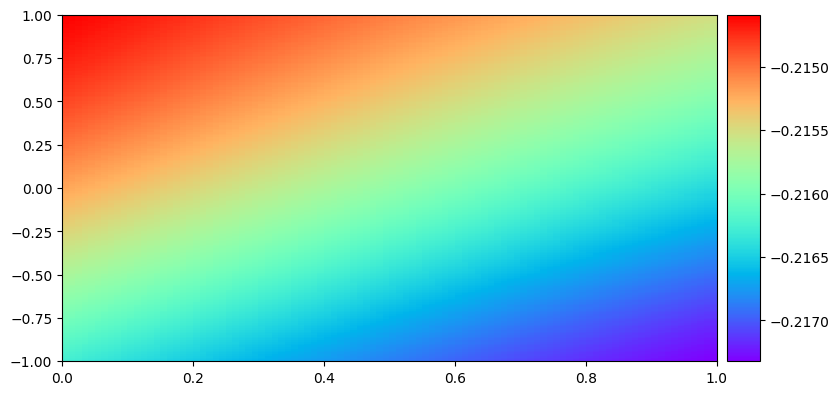

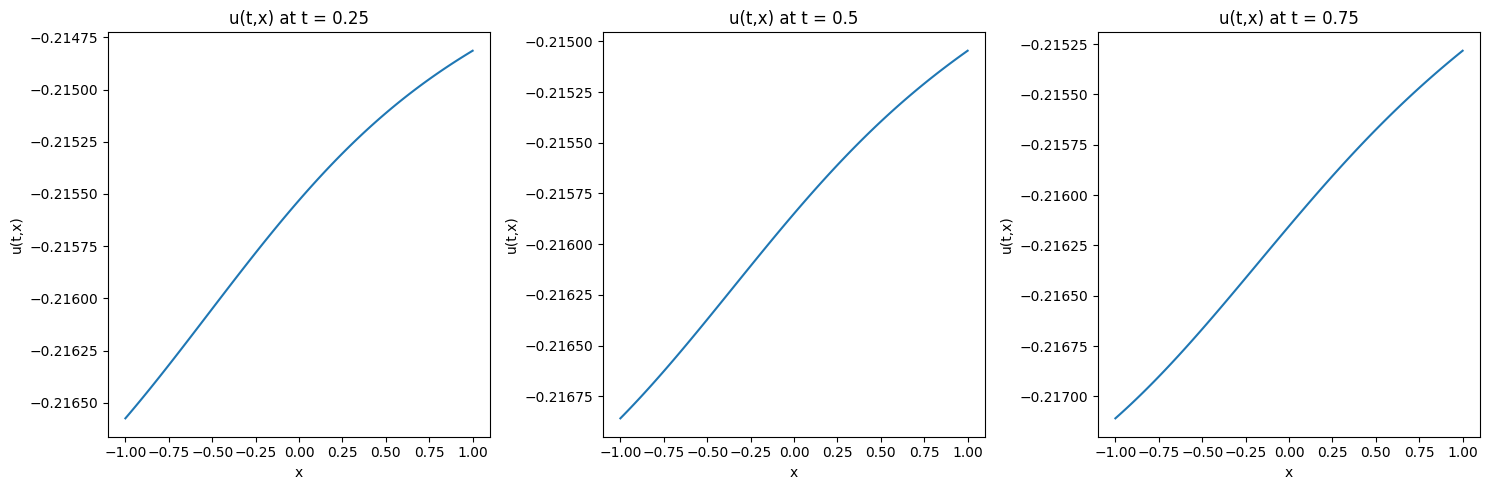

x_first:tensor([0.6920], grad_fn=<SelectBackward0>), t_first:tensor([0.], grad_fn=<SelectBackward0>), solution:tensor([-0.8236])
First predicted value: -0.0011002073297277093


In [46]:
pinn.plot()
t_values = [0.25, 0.5, 0.75]
x_range = np.linspace(-1, 1, 100)  # Define the range of x values

# Call the plot function
pinn.plot_u_vs_x(t_values, x_range)

# Assuming self.x_u and self.t_u are tensors containing the input coordinates
x_first = pinn.x_u[0]  # First value of x
t_first = pinn.t_u[0]  # First value of t

# Compute the predicted solution using the neural network
predicted_value = pinn.net_f(x_first, t_first)

# Convert the predicted value to a scalar
predicted_value = predicted_value.item()
# print(f"solution vector:{torch.hstack((pinn.x_u,pinn.t_u,pinn.u))}")

print(f"x_first:{x_first}, t_first:{t_first}, solution:{pinn.u[0]}")
print("First predicted value:", predicted_value)

### Training

In [ ]:
pinn.train()
pinn.save_model("model_0.pth")

Epoch: 100, Loss:  0.082
Epoch: 200, Loss:  0.047
Epoch: 300, Loss:  0.033
Epoch: 400, Loss:  0.014
Epoch: 500, Loss:  0.007
Epoch: 600, Loss:  0.004
Epoch: 700, Loss:  0.003
Epoch: 800, Loss:  0.002
Epoch: 900, Loss:  0.002
Epoch: 1000, Loss:  0.001
Epoch: 1100, Loss:  0.001
Epoch: 1200, Loss:  0.001
Epoch: 1300, Loss:  0.001
Epoch: 1400, Loss:  0.001
Epoch: 1500, Loss:  0.000
Epoch: 1600, Loss:  0.000
Epoch: 1700, Loss:  0.000
Epoch: 1800, Loss:  0.000
Epoch: 1900, Loss:  0.000
Epoch: 2000, Loss:  0.000
Epoch: 2100, Loss:  0.000
Epoch: 2200, Loss:  0.000
Epoch: 2300, Loss:  0.000
Epoch: 2400, Loss:  0.000
Epoch: 2500, Loss:  0.000
Epoch: 2600, Loss:  0.000
Epoch: 2700, Loss:  0.000
Epoch: 2800, Loss:  0.000
Epoch: 2900, Loss:  0.000
Epoch: 3000, Loss:  0.000
Epoch: 3100, Loss:  0.000
Epoch: 3200, Loss:  0.000
Epoch: 3300, Loss:  0.000
Epoch: 3400, Loss:  0.000
Epoch: 3500, Loss:  0.000
Epoch: 3600, Loss:  0.000
Epoch: 3700, Loss:  0.000
Epoch: 3800, Loss:  0.000
Epoch: 3900, Loss:  0

####plot after training

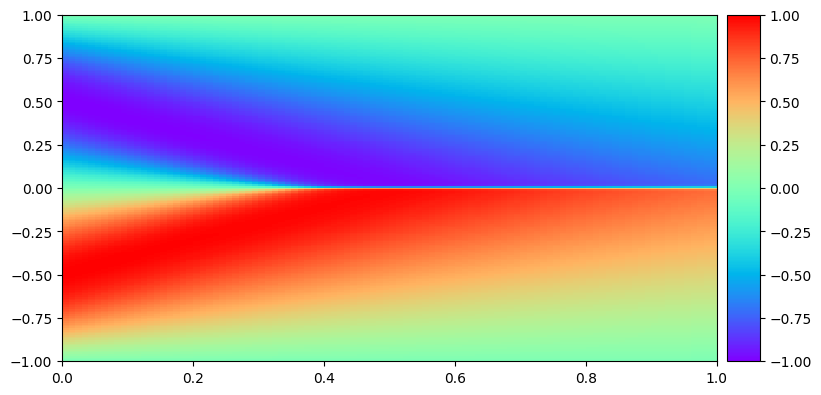

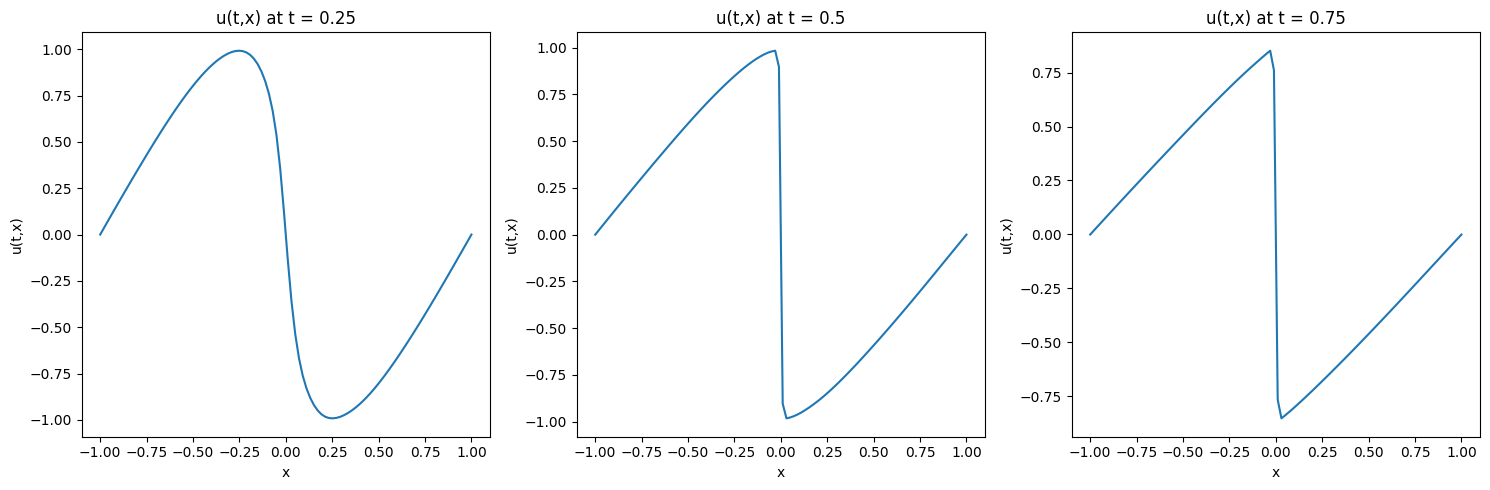

x_first:tensor([-1.], grad_fn=<SelectBackward0>), t_first:tensor([0.5937], grad_fn=<SelectBackward0>), solution:tensor([0.])
First predicted value: 0.0005659117014147341


In [ ]:
pinn.plot()
t_values = [0.25, 0.5, 0.75]
x_range = np.linspace(-1, 1, 100)  # Define the range of x values

# Call the plot function
pinn.plot_u_vs_x(t_values, x_range)

# Assuming self.x_u and self.t_u are tensors containing the input coordinates
x_first = pinn.x_u[0]  # First value of x
t_first = pinn.t_u[0]  # First value of t

# Compute the predicted solution using the neural network
predicted_value = pinn.net_f(x_first, t_first)

# Convert the predicted value to a scalar
predicted_value = predicted_value.item()
# print(f"solution vector:{torch.hstack((pinn.x_u,pinn.t_u,pinn.u))}")

print(f"x_first:{x_first}, t_first:{t_first}, solution:{pinn.u[0]}")
print("First predicted value:", predicted_value)

###load saved model

Model loaded successfully.


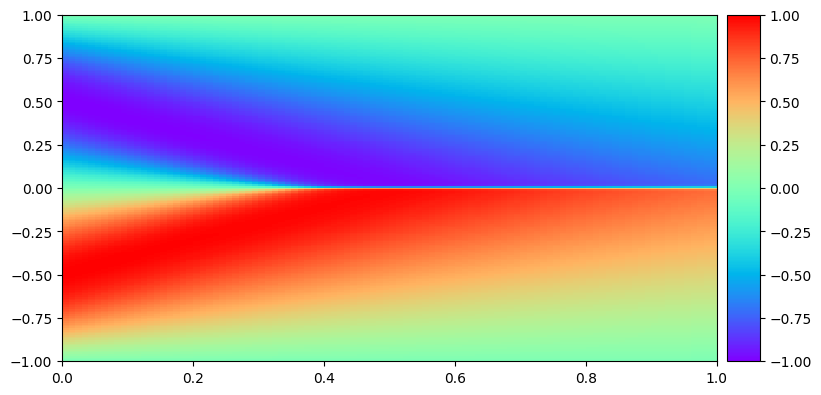

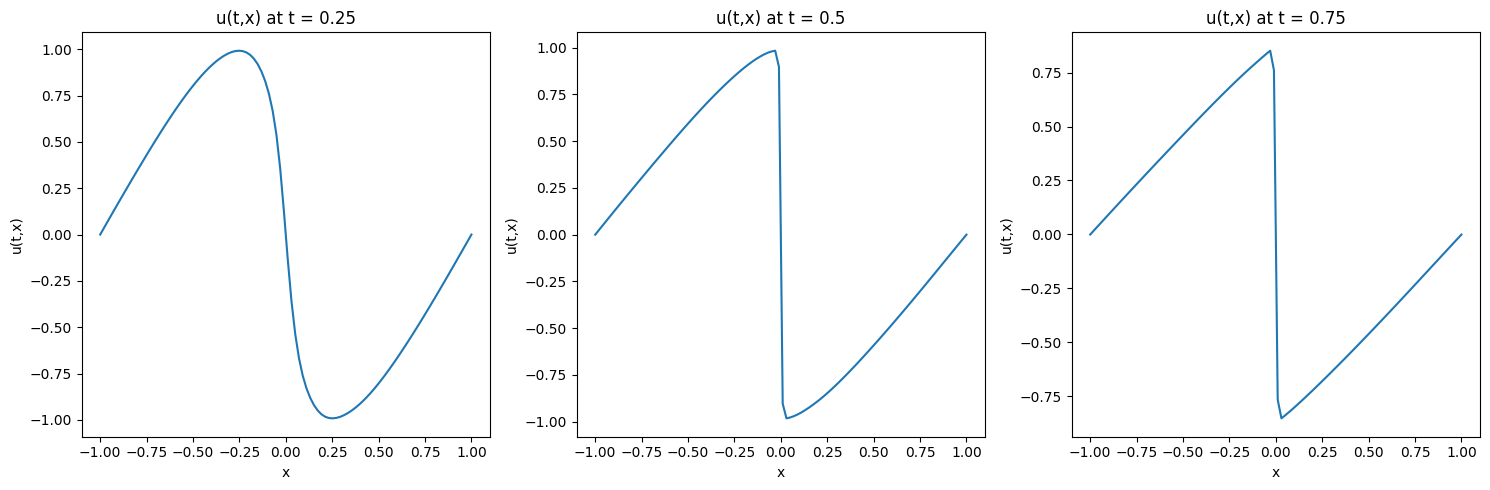

x_first:tensor([0.6920], grad_fn=<SelectBackward0>), t_first:tensor([0.], grad_fn=<SelectBackward0>), solution:tensor([-0.8236])
First predicted value: -0.0014082212001085281


In [47]:
pinn.load_model("model_0.pth")
pinn.plot()
t_values = [0.25, 0.5, 0.75]
x_range = np.linspace(-1, 1, 100)  # Define the range of x values

# Call the plot function
pinn.plot_u_vs_x(t_values, x_range)

# Assuming self.x_u and self.t_u are tensors containing the input coordinates
x_first = pinn.x_u[0]  # First value of x
t_first = pinn.t_u[0]  # First value of t

# Compute the predicted solution using the neural network
predicted_value = pinn.net_f(x_first, t_first)

# Convert the predicted value to a scalar
predicted_value = predicted_value.item()
# print(f"solution vector:{torch.hstack((pinn.x_u,pinn.t_u,pinn.u))}")

print(f"x_first:{x_first}, t_first:{t_first}, solution:{pinn.u[0]}")
print("First predicted value:", predicted_value)